## Scientific Research Article Topic Classification

In [2]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, GlobalMaxPooling1D
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.models import Model

#### Data Preparation:

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/Data/train.csv")

In [5]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


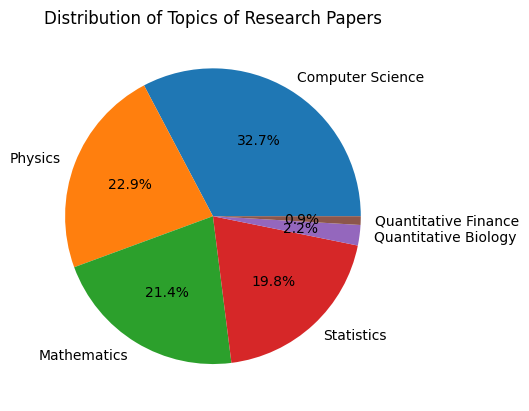

In [6]:
cs_counts = (train_df['Computer Science'] == 1).sum()
phy_counts = (train_df['Physics'] == 1).sum()
math_counts = (train_df['Mathematics'] == 1).sum()
stats_counts = (train_df['Statistics'] == 1).sum()
quantbio_counts = (train_df['Quantitative Biology'] == 1).sum()
quantfin_counts = (train_df['Quantitative Finance'] == 1).sum()

categories = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
counts = [cs_counts, phy_counts, math_counts, stats_counts, quantbio_counts, quantfin_counts]

plt.pie(counts, labels=categories, autopct='%1.1f%%')
plt.title('Distribution of Topics of Research Papers')

plt.show()

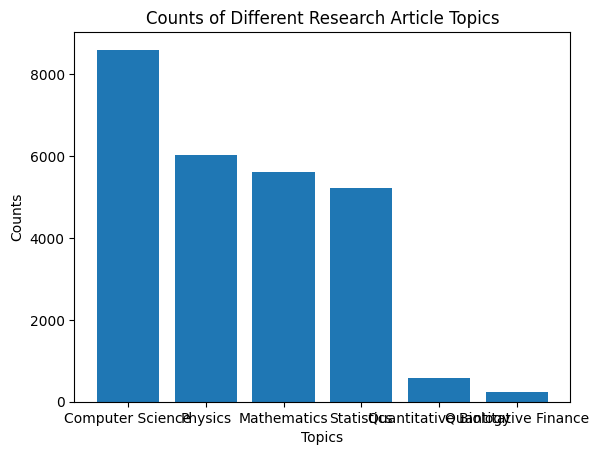

In [7]:
cs_counts = (train_df['Computer Science'] == 1).sum()
phy_counts = (train_df['Physics'] == 1).sum()
math_counts = (train_df['Mathematics'] == 1).sum()
stats_counts = (train_df['Statistics'] == 1).sum()
quantbio_counts = (train_df['Quantitative Biology'] == 1).sum()
quantfin_counts = (train_df['Quantitative Finance'] == 1).sum()

categories = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
counts = [cs_counts, phy_counts, math_counts, stats_counts, quantbio_counts, quantfin_counts]

plt.bar(categories, counts)
plt.xlabel('Topics')
plt.ylabel('Counts')
plt.title('Counts of Different Research Article Topics')

plt.show()

In [8]:
train_df.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [9]:
train_df.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [10]:
train_df["Info"] = train_df['TITLE'].astype(str) +":"+ train_df["ABSTRACT"]

In [11]:
train_df.drop(['TITLE', 'ABSTRACT'], axis=1)

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Info
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps: ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network: Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...
...,...,...,...,...,...,...,...,...
20967,20968,1,1,0,0,0,0,Contemporary machine learning: a guide for pra...
20968,20969,0,1,0,0,0,0,Uniform diamond coatings on WC-Co hard alloy c...
20969,20970,1,0,0,0,0,0,Analysing Soccer Games with Clustering and Con...
20970,20971,0,0,1,1,0,0,On the Efficient Simulation of the Left-Tail o...


In [12]:
columns_to_predict = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [13]:
input_data = train_df['Info'].values
labels = train_df[columns_to_predict].values

In [14]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(input_data)
sequences = tokenizer.texts_to_sequences(input_data)

In [15]:
# Padding
vocab_size = len(tokenizer.word_index) + 1
max_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

#### Approach 1: LSTM

In [16]:
# Model definition
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
model.add(LSTM(128))
model.add(Dense(len(columns_to_predict), activation='sigmoid'))

In [17]:
# Model compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 467, 100)          5797800   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 5,915,822
Trainable params: 5,915,822
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Model training
history = model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
525/525 [==============================] - 94s 167ms/step - loss: 0.3578 - accuracy: 0.5910 - val_loss: 0.2700 - val_accuracy: 0.7461
Epoch 2/10
525/525 [==============================] - 31s 59ms/step - loss: 0.2420 - accuracy: 0.7583 - val_loss: 0.2575 - val_accuracy: 0.7616
Epoch 3/10
525/525 [==============================] - 21s 39ms/step - loss: 0.1862 - accuracy: 0.7737 - val_loss: 0.2281 - val_accuracy: 0.7428
Epoch 4/10
525/525 [==============================] - 19s 37ms/step - loss: 0.1454 - accuracy: 0.7967 - val_loss: 0.2360 - val_accuracy: 0.7538
Epoch 5/10
525/525 [==============================] - 15s 29ms/step - loss: 0.1087 - accuracy: 0.8228 - val_loss: 0.2565 - val_accuracy: 0.7449
Epoch 6/10
525/525 [==============================] - 15s 29ms/step - loss: 0.0807 - accuracy: 0.8412 - val_loss: 0.2845 - val_accuracy: 0.7390
Epoch 7/10
525/525 [==============================] - 14s 26ms/step - loss: 0.0564 - accuracy: 0.8488 - val_loss: 0.3085 - val_accuracy

In [20]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')

    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

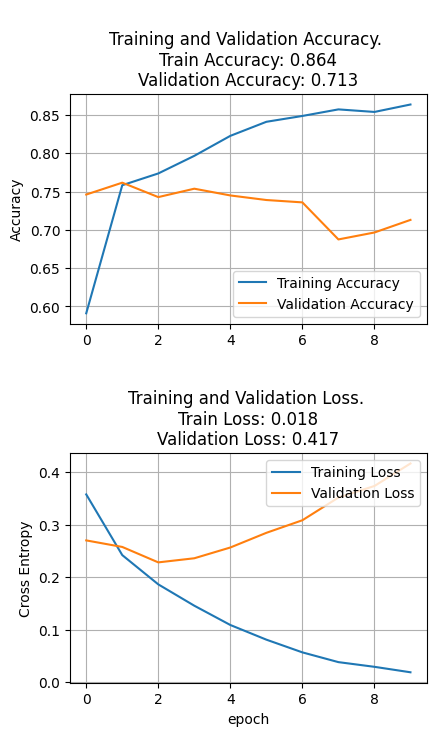

In [21]:
plot_history(history)

##### Prediction:

In [22]:
# Load the test data from CSV
test_df = pd.read_csv('/content/drive/MyDrive/Data/test.csv')

test_df.head()

# Combine 'TITLES' and 'ABSTRACT' into a single column 'Info'
test_df['Info'] = test_df['TITLE'] + ' ' + test_df['ABSTRACT']

# Tokenize and pad the text sequences
sequences = tokenizer.texts_to_sequences(test_df['Info'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Make predictions using the trained model
predictions = model.predict(padded_sequences)

# Create a DataFrame to store the results
results_df = pd.DataFrame(predictions, columns=columns_to_predict)

# Add the 'Id' column from the test data to the results DataFrame
results_df['ID'] = test_df['ID']

# Rearrange the columns to have 'Id' as the first column
results_df = results_df[['ID'] + columns_to_predict]

# Show the results
results_df.head()

281/281 [==============================] - 3s 9ms/step


,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0.620350,0.001808,0.001040,0.998560,0.005977,0.001233
1,20974,0.000063,0.999927,0.000120,0.000221,0.000029,0.000006
2,20975,0.999812,0.000072,0.000195,0.001654,0.000118,0.000033
3,20976,0.000083,0.999946,0.000048,0.000807,0.000067,0.000005
4,20977,0.986169,0.001657,0.999232,0.001318,0.000475,0.000357


#### Approach 2: Bi-directional LSTM

In [23]:
# Model definition
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(len(columns_to_predict), activation='sigmoid'))

In [24]:
# Model Compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# Model training
history = model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
225/225 [==============================] - 41s 166ms/step - loss: 0.4506 - accuracy: 0.4005 - val_loss: 0.4350 - val_accuracy: 0.3910
Epoch 2/10
225/225 [==============================] - 24s 107ms/step - loss: 0.4313 - accuracy: 0.4253 - val_loss: 0.4394 - val_accuracy: 0.3576
Epoch 3/10
225/225 [==============================] - 16s 72ms/step - loss: 0.3623 - accuracy: 0.5533 - val_loss: 0.5002 - val_accuracy: 0.3087
Epoch 4/10
225/225 [==============================] - 14s 64ms/step - loss: 0.2599 - accuracy: 0.6846 - val_loss: 0.5813 - val_accuracy: 0.2775
Epoch 5/10
225/225 [==============================] - 15s 67ms/step - loss: 0.1798 - accuracy: 0.7618 - val_loss: 0.7181 - val_accuracy: 0.2870
Epoch 6/10
225/225 [==============================] - 16s 72ms/step - loss: 0.1232 - accuracy: 0.8138 - val_loss: 0.8372 - val_accuracy: 0.2775
Epoch 7/10
225/225 [==============================] - 20s 90ms/step - loss: 0.0822 - accuracy: 0.8387 - val_loss: 0.9912 - val_accurac

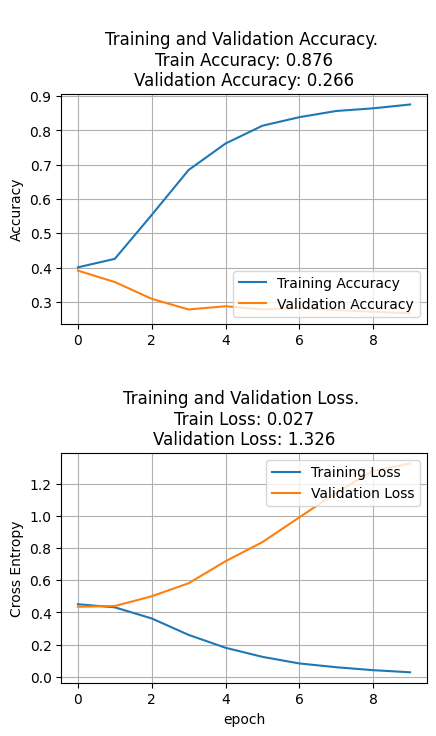

In [26]:
plot_history(history)

#### Approach 3: CNN

In [41]:
# Model Definition
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(len(columns_to_predict), activation='sigmoid'))

In [42]:
# Model compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 467, 100)          5797800   
                                                                 
 conv1d_1 (Conv1D)           (None, 465, 64)           19264     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 5,817,454
Trainable params: 5,817,454
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
225/225 [==============================] - 30s 135ms/step - loss: 0.4690 - accuracy: 0.3846 - val_loss: 0.4336 - val_accuracy: 0.3910
Epoch 2/10
225/225 [==============================] - 17s 75ms/step - loss: 0.4282 - accuracy: 0.4098 - val_loss: 0.4336 - val_accuracy: 0.3910
Epoch 3/10
225/225 [==============================] - 13s 56ms/step - loss: 0.3904 - accuracy: 0.5380 - val_loss: 0.4389 - val_accuracy: 0.3437
Epoch 4/10
225/225 [==============================] - 8s 36ms/step - loss: 0.2914 - accuracy: 0.7808 - val_loss: 0.4632 - val_accuracy: 0.3426
Epoch 5/10
225/225 [==============================] - 6s 28ms/step - loss: 0.1619 - accuracy: 0.8696 - val_loss: 0.5149 - val_accuracy: 0.3231
Epoch 6/10
225/225 [==============================] - 4s 16ms/step - loss: 0.0770 - accuracy: 0.8979 - val_loss: 0.5658 - val_accuracy: 0.3165
Epoch 7/10
225/225 [==============================] - 4s 16ms/step - loss: 0.0372 - accuracy: 0.9081 - val_loss: 0.6307 - val_accuracy: 0.

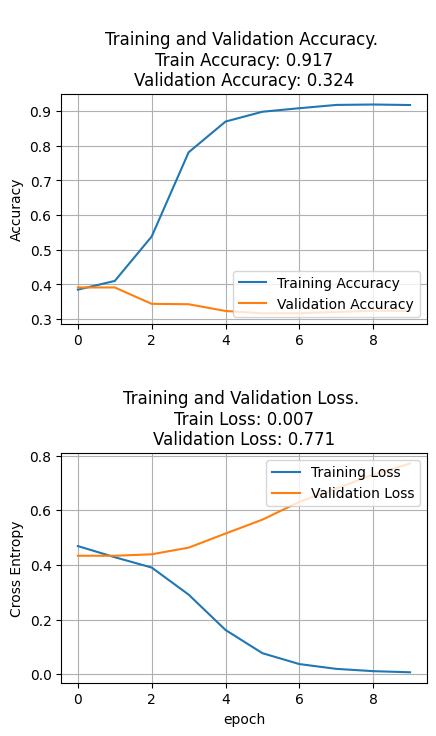

In [46]:
 plot_history(history)